In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [6]:
syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

In [7]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [8]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

,en,au,ce,cj,ah,bm,ch,ai,db,aj,ck,hg,ac,ci,fq,ec,df,bx,cr,cl
0,2995,2077,1620,1506,1418,1379,1363,1362,1358,1305,1233,1180,1179,1080,1007,1003,986,984,978,971


In [9]:
sylllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

In [10]:
sylllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
12,114.757543,114.986067,bm,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.03662450122476042, -0.022604548403189744, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [11]:
sylllable_df = sylllable_df.reset_index()

In [12]:
specs = np.array(list(sylllable_df.spectrogram.values))
specs.shape

(26984, 32, 31)

In [13]:
sylllable_df['subset'] = 'train'
sylllable_df.loc[:1000, 'subset'] = 'valid'
sylllable_df.loc[1000:1999, 'subset'] = 'test'

In [14]:
len(sylllable_df)

26984

In [15]:
Y_train = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'train']))
Y_valid = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'valid']))
Y_test = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'test']))

In [16]:
X_train = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'test'])) #/ 255.

In [17]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()

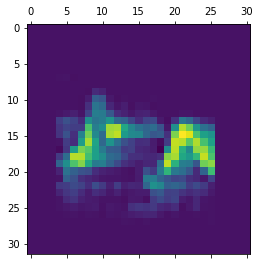

In [19]:
plt.matshow(X_train[10])

### Prepare metric

In [20]:
from tfumap.dtw_mse import build_dtw_mse

In [22]:
dtw_metric = build_dtw_mse(X_train[0].shape)

### Create model and train

In [23]:
embedder = tfUMAP(
    metric=dtw_metric,
    direct_embedding=True,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=100,
)

In [24]:
z = embedder.fit_transform(X_train_flat)

/mnt/cube/tsainbur/Projects/github_repos/umap/umap/umap_.py:1624: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


tfUMAP(direct_embedding=True, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7fd386a09198>,
       tensorboard_logdir='/tmp/tensorboard/20200707-155200',
       training_epochs=100)
Construct fuzzy simplicial set
Tue Jul  7 15:52:03 2020 Finding Nearest Neighbors
Tue Jul  7 15:52:03 2020 Building RP forest with 13 trees
Tue Jul  7 15:52:04 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Tue Jul  7 16:31:20 2020 Finished Nearest Neighbor Search
Tue Jul  7 16:31:25 2020 Embedding with TensorFlow


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tue Jul  7 16:34:25 2020 Finished embedding


### Plot model output

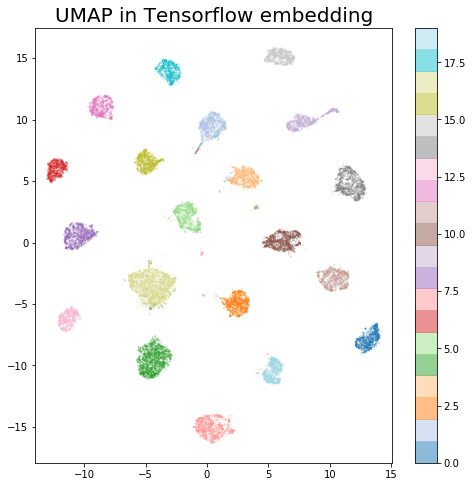

In [25]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train[:len(z)],
    cmap="tab20",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [26]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [27]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594165e+09,1,1.727745,train,umap_loss
1,1.594165e+09,2,1.557880,train,umap_loss
2,1.594165e+09,3,1.433877,train,umap_loss


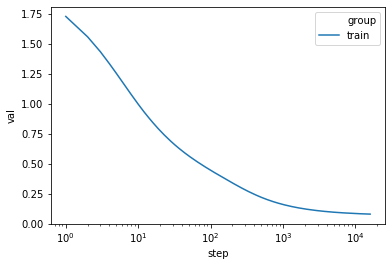

In [28]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Save output

In [29]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [30]:
output_dir = MODEL_DIR/'projections'/ 'cassins_dtw' / 'direct'
ensure_dir(output_dir)

In [31]:
embedder.save(output_dir)

Pickle of model saved


In [32]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [33]:
np.save(output_dir / 'z.npy', z)

### Compare to direct embedding with base UMAP

In [34]:
from umap import UMAP

In [35]:
z_umap = UMAP(metric = dtw_metric, verbose=True).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0,
     metric=CPUDispatcher(<function build_dtw_mse.<locals>.dtw_mse at 0x7fd3892c98c8>),
     verbose=True)


/mnt/cube/tsainbur/Projects/github_repos/umap/umap/umap_.py:1624: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Construct fuzzy simplicial set
Tue Jul  7 16:34:36 2020 Finding Nearest Neighbors
Tue Jul  7 16:34:36 2020 Building RP forest with 13 trees
Tue Jul  7 16:34:36 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Tue Jul  7 17:13:22 2020 Finished Nearest Neighbor Search
Tue Jul  7 17:13:22 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jul  7 17:13:39 2020 Finished embedding


In [36]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.7039109926583399


Text(0.5, 1.0, 'UMAP with UMAP-learn')

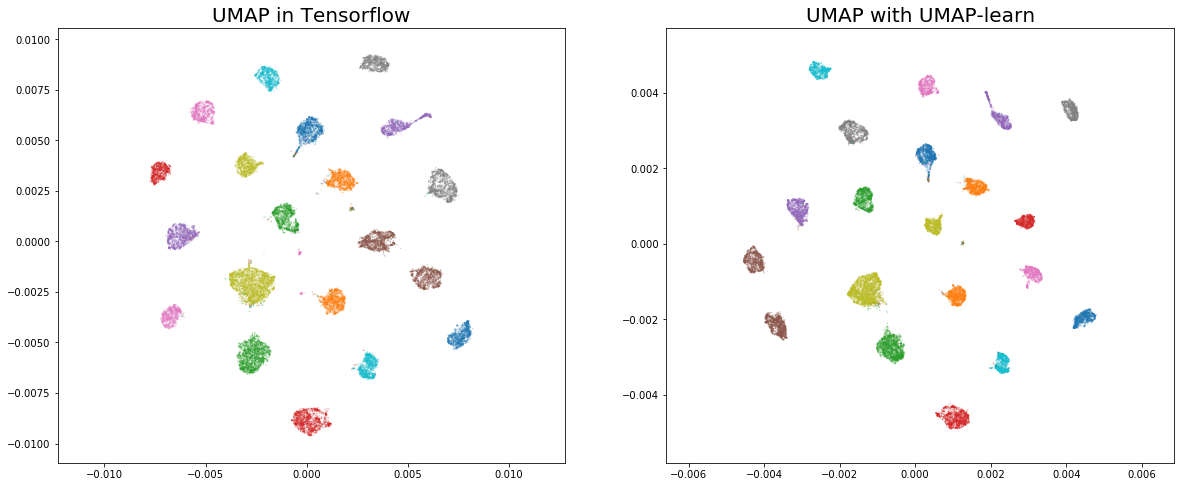

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);